In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import time
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [ ]:
# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
trainset, valset = random_split(dataset, [train_size, val_size])

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:04<00:00, 38.3MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.relu(x)
        return x

class StandardConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(StandardConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        return x

class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers, conv_type='depthwise'):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            if conv_type == 'depthwise':
                self.layers.append(DepthwiseSeparableConv(in_channels, growth_rate))
            else:
                self.layers.append(StandardConv(in_channels, growth_rate))
            in_channels += growth_rate

    def forward(self, x):
        for layer in self.layers:
            out = layer(x)
            x = torch.cat([x, out], dim=1)
        return x

class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.pool = nn.AvgPool2d(2, 2)

    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x)
        return x

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, conv_type='depthwise'):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        self.block1 = DenseBlock(64, 32, 4, conv_type)
        self.trans1 = TransitionLayer(192, 128)

        self.block2 = DenseBlock(128, 32, 4, conv_type)
        self.trans2 = TransitionLayer(256, 128)

        self.block3 = DenseBlock(128, 32, 4, conv_type)
        self.trans3 = TransitionLayer(256, 512)

        self.block4 = DenseBlock(512, 32, 4, conv_type)
        self.trans4 = TransitionLayer(640, 1024)

        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.trans1(self.block1(x))
        x = self.trans2(self.block2(x))
        x = self.trans3(self.block3(x))
        x = self.trans4(self.block4(x))
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [ ]:
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=100, patience=10, device='cpu'):
    best_val_loss = float('inf')
    stagnant_epochs = 0
    start_time = time.time()
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for images, labels in valloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_loss /= len(valloader)
        train_losses.append(running_loss / len(trainloader))
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}, Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            stagnant_epochs = 0
            torch.save(model.state_dict(), "best_model.pth")
        else:
            stagnant_epochs += 1

        if stagnant_epochs >= patience:
            print("Early stopping triggered.")
            break

    training_time = time.time() - start_time
    print(f"Training Time: {training_time:.2f} seconds")

      # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    return training_time, val_losses[-1]

In [ ]:
# Initialize and train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel(conv_type='depthwise').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1, Loss: 1.7995, Val Loss: 1.6458
Epoch 2, Loss: 1.4748, Val Loss: 1.2935
Epoch 3, Loss: 1.2302, Val Loss: 1.1367
Epoch 4, Loss: 1.0572, Val Loss: 1.0039
Epoch 5, Loss: 0.9498, Val Loss: 0.9149
Epoch 6, Loss: 0.8649, Val Loss: 0.8239
Epoch 7, Loss: 0.7847, Val Loss: 0.8340
Epoch 8, Loss: 0.7150, Val Loss: 0.7533
Epoch 9, Loss: 0.6612, Val Loss: 0.7046
Epoch 10, Loss: 0.6065, Val Loss: 0.6631
Epoch 11, Loss: 0.5640, Val Loss: 0.6671
Epoch 12, Loss: 0.5290, Val Loss: 0.6123
Epoch 13, Loss: 0.4802, Val Loss: 0.6566
Epoch 14, Loss: 0.4504, Val Loss: 0.5885
Epoch 15, Loss: 0.4169, Val Loss: 0.6319
Epoch 16, Loss: 0.3847, Val Loss: 0.6252
Epoch 17, Loss: 0.3525, Val Loss: 0.6372
Epoch 18, Loss: 0.3360, Val Loss: 0.6465
Epoch 19, Loss: 0.3161, Val Loss: 0.7374
Epoch 20, Loss: 0.2783, Val Loss: 0.7249
Epoch 21, Loss: 0.2674, Val Loss: 0.6881
Epoch 22, Loss: 0.2502, Val Loss: 0.6764
Epoch 23, Loss: 0.2243, Val Loss: 0.7362
Epoch 24, Loss: 0.2187, Val Loss: 0.7001
Early stopping triggered.

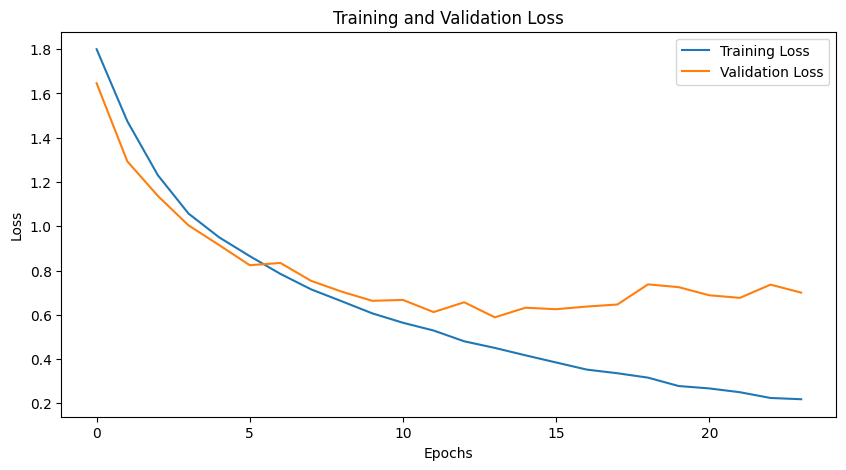

<ipython-input-7-e71793b1b27f>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


<All keys matched successfully>

In [ ]:
train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=100, patience=10, device=device)

# Load the best model
model.load_state_dict(torch.load("best_model.pth"))

In [ ]:
# Evaluate the model
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

accuracy = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(10)])

print(f"Test Accuracy: {accuracy:.4f}")
print(report)

Test Accuracy: 0.8030
              precision    recall  f1-score   support

           0       0.74      0.89      0.81      1000
           1       0.90      0.91      0.90      1000
           2       0.75      0.68      0.71      1000
           3       0.62      0.66      0.64      1000
           4       0.82      0.77      0.79      1000
           5       0.73      0.73      0.73      1000
           6       0.83      0.85      0.84      1000
           7       0.90      0.78      0.84      1000
           8       0.91      0.90      0.90      1000
           9       0.88      0.87      0.87      1000

    accuracy                           0.80     10000
   macro avg       0.81      0.80      0.80     10000
weighted avg       0.81      0.80      0.80     10000



<ipython-input-9-fa8259b29ce8>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


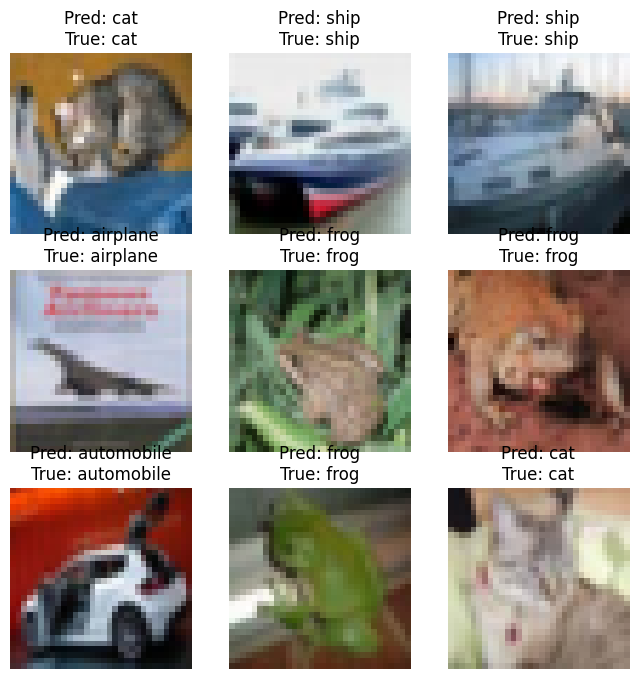

In [ ]:
# Visualize some predictions
def visualize_predictions(model, testloader, device):
    model.eval()
    images, labels = next(iter(testloader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    classes = testset.classes
    for i, ax in enumerate(axes.flat):
        img = images[i].cpu().permute(1, 2, 0).numpy()
        ax.imshow((img * 0.5) + 0.5)  # Unnormalize
        ax.set_title(f"Pred: {classes[preds[i]]}\nTrue: {classes[labels[i]]}")
        ax.axis('off')
    plt.show()

# Load the best model
model.load_state_dict(torch.load("best_model.pth"))
visualize_predictions(model, testloader, device)

In [ ]:
def compare_models():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    criterion = nn.CrossEntropyLoss()

    print("Training Depthwise Separable CNN...")
    model_depthwise = CNNModel('depthwise').to(device)
    optimizer = optim.Adam(model_depthwise.parameters(), lr=0.001)
    depthwise_time, _ = train_model(model_depthwise, trainloader, valloader, criterion, optimizer, num_epochs=15, device=device)

    print("Training Standard CNN...")
    model_standard = CNNModel('standard').to(device)
    optimizer = optim.Adam(model_standard.parameters(), lr=0.001)
    standard_time, _ = train_model(model_standard, trainloader, valloader, criterion, optimizer, num_epochs=15, device=device)

    depthwise_params = sum(p.numel() for p in model_depthwise.parameters())
    standard_params = sum(p.numel() for p in model_standard.parameters())

    print(f"Depthwise Separable Model Params: {depthwise_params}")
    print(f"Standard Conv Model Params: {standard_params}")
    print(f"Depthwise Separable Model Training Time: {depthwise_time:.2f} sec")
    print(f"Standard Conv Model Training Time: {standard_time:.2f} sec")

Training Depthwise Separable CNN...
Epoch 1, Loss: 1.8206, Val Loss: 1.6126
Epoch 2, Loss: 1.4974, Val Loss: 1.3294
Epoch 3, Loss: 1.2582, Val Loss: 1.1433
Epoch 4, Loss: 1.1028, Val Loss: 1.1006
Epoch 5, Loss: 0.9974, Val Loss: 0.9254
Epoch 6, Loss: 0.9128, Val Loss: 0.9426
Epoch 7, Loss: 0.8428, Val Loss: 0.8317
Epoch 8, Loss: 0.7756, Val Loss: 0.7972
Epoch 9, Loss: 0.7070, Val Loss: 0.7558
Epoch 10, Loss: 0.6630, Val Loss: 0.7013
Epoch 11, Loss: 0.6114, Val Loss: 0.6883
Epoch 12, Loss: 0.5680, Val Loss: 0.6534
Epoch 13, Loss: 0.5329, Val Loss: 0.6087
Epoch 14, Loss: 0.4872, Val Loss: 0.6488
Epoch 15, Loss: 0.4487, Val Loss: 0.6323
Training Time: 516.69 seconds


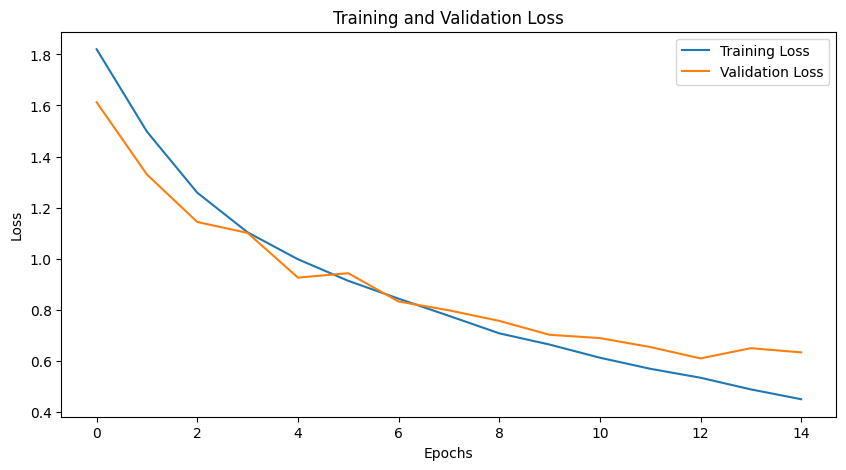

Training Standard CNN...
Epoch 1, Loss: 1.5572, Val Loss: 1.2358
Epoch 2, Loss: 1.0615, Val Loss: 0.9218
Epoch 3, Loss: 0.8211, Val Loss: 0.8268
Epoch 4, Loss: 0.6990, Val Loss: 0.7527
Epoch 5, Loss: 0.6085, Val Loss: 0.6690
Epoch 6, Loss: 0.5297, Val Loss: 0.6401
Epoch 7, Loss: 0.4694, Val Loss: 0.6305
Epoch 8, Loss: 0.4203, Val Loss: 0.7570
Epoch 9, Loss: 0.3775, Val Loss: 0.7270
Epoch 10, Loss: 0.3414, Val Loss: 0.7038
Epoch 11, Loss: 0.3058, Val Loss: 0.7264
Epoch 12, Loss: 0.2706, Val Loss: 0.7447
Epoch 13, Loss: 0.2512, Val Loss: 0.6957
Epoch 14, Loss: 0.2256, Val Loss: 0.7226
Epoch 15, Loss: 0.2054, Val Loss: 0.8205
Training Time: 628.88 seconds


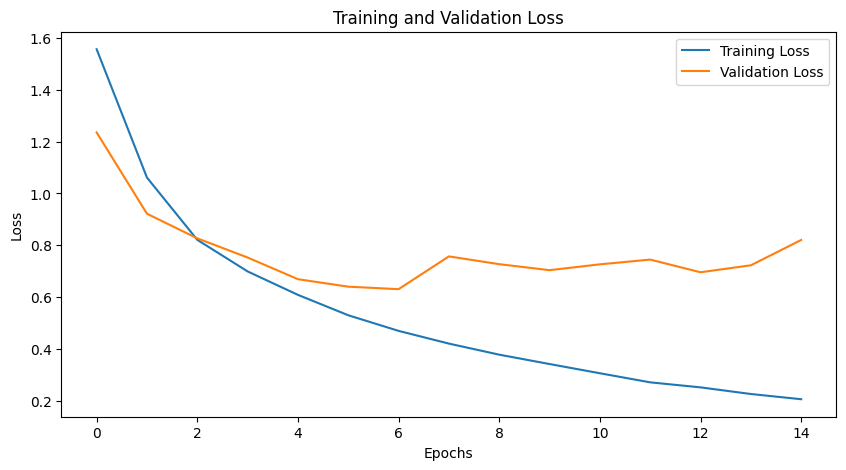

Depthwise Separable Model Params: 1030282
Standard Conv Model Params: 2037898
Depthwise Separable Model Training Time: 516.69 sec
Standard Conv Model Training Time: 628.88 sec


In [ ]:
compare_models()

In [ ]:
def hyperparameter_tuning():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    criterion = nn.CrossEntropyLoss()
    learning_rates = [0.01, 0.001, 0.0001]
    optimizers = ['SGD', 'Adam']
    best_model = None
    best_val_loss = float('inf')
    best_hyperparams = {}

    for lr, opt_name in itertools.product(learning_rates, optimizers):
        print(f"Testing model with LR={lr}, Optimizer={opt_name}")
        model = CNNModel('depthwise').to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr) if opt_name == 'SGD' else optim.Adam(model.parameters(), lr=lr)
        _, val_loss = train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=20, patience=5, device=device)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model
            best_hyperparams = {'learning_rate': lr, 'optimizer': opt_name}

    print(f"Best Hyperparameters: {best_hyperparams}")
    return best_model, best_hyperparams

Testing model with LR=0.01, Optimizer=SGD
Epoch 1, Loss: 2.2923, Val Loss: 2.2684
Epoch 2, Loss: 2.1763, Val Loss: 2.1127
Epoch 3, Loss: 2.0945, Val Loss: 2.0885
Epoch 4, Loss: 2.0651, Val Loss: 2.0526
Epoch 5, Loss: 2.0148, Val Loss: 1.9776
Epoch 6, Loss: 1.9325, Val Loss: 1.8891
Epoch 7, Loss: 1.8650, Val Loss: 1.8224
Epoch 8, Loss: 1.8262, Val Loss: 1.7950
Epoch 9, Loss: 1.8028, Val Loss: 1.7642
Epoch 10, Loss: 1.7819, Val Loss: 1.7399
Epoch 11, Loss: 1.7638, Val Loss: 1.7623
Epoch 12, Loss: 1.7478, Val Loss: 1.7109
Epoch 13, Loss: 1.7310, Val Loss: 1.7193
Epoch 14, Loss: 1.7206, Val Loss: 1.7112
Epoch 15, Loss: 1.7162, Val Loss: 1.6802
Epoch 16, Loss: 1.7042, Val Loss: 1.6750
Epoch 17, Loss: 1.6964, Val Loss: 1.6616
Epoch 18, Loss: 1.6893, Val Loss: 1.6550
Epoch 19, Loss: 1.6827, Val Loss: 1.6742
Epoch 20, Loss: 1.6723, Val Loss: 1.6374
Training Time: 680.41 seconds


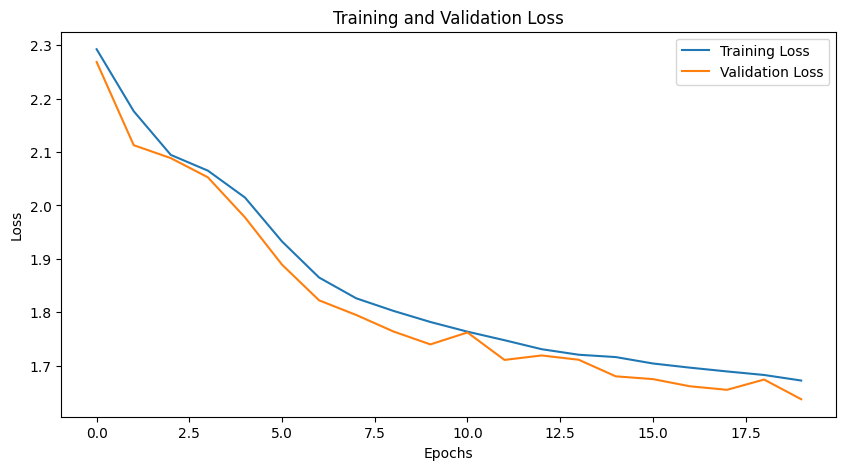

Testing model with LR=0.01, Optimizer=Adam
Epoch 1, Loss: 2.1255, Val Loss: 1.8065
Epoch 2, Loss: 1.8171, Val Loss: 1.7906
Epoch 3, Loss: 1.7489, Val Loss: 1.6162
Epoch 4, Loss: 1.6154, Val Loss: 1.5423
Epoch 5, Loss: 1.5228, Val Loss: 1.4905
Epoch 6, Loss: 1.4762, Val Loss: 1.4278
Epoch 7, Loss: 9598.9313, Val Loss: 315.7086
Epoch 8, Loss: 124.5292, Val Loss: 36.6646
Epoch 9, Loss: 36.5065, Val Loss: 14.3652
Epoch 10, Loss: 14.1776, Val Loss: 9.8301
Epoch 11, Loss: 6.8094, Val Loss: 6.0776
Early stopping triggered.
Training Time: 369.17 seconds


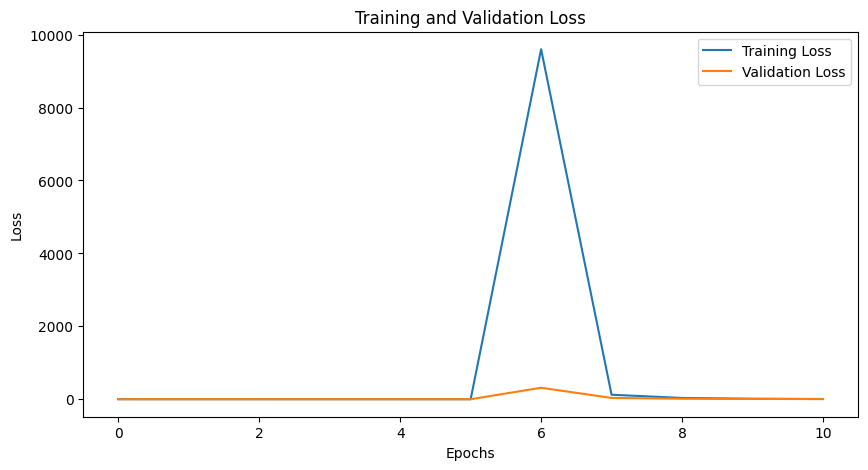

Testing model with LR=0.001, Optimizer=SGD
Epoch 1, Loss: 2.3029, Val Loss: 2.3024
Epoch 2, Loss: 2.3018, Val Loss: 2.3013
Epoch 3, Loss: 2.3006, Val Loss: 2.3001
Epoch 4, Loss: 2.2994, Val Loss: 2.2988
Epoch 5, Loss: 2.2980, Val Loss: 2.2974
Epoch 6, Loss: 2.2965, Val Loss: 2.2956
Epoch 7, Loss: 2.2946, Val Loss: 2.2935
Epoch 8, Loss: 2.2923, Val Loss: 2.2909
Epoch 9, Loss: 2.2892, Val Loss: 2.2870
Epoch 10, Loss: 2.2852, Val Loss: 2.2823
Epoch 11, Loss: 2.2797, Val Loss: 2.2764
Epoch 12, Loss: 2.2720, Val Loss: 2.2667
Epoch 13, Loss: 2.2613, Val Loss: 2.2535
Epoch 14, Loss: 2.2463, Val Loss: 2.2363
Epoch 15, Loss: 2.2262, Val Loss: 2.2136
Epoch 16, Loss: 2.2022, Val Loss: 2.1895
Epoch 17, Loss: 2.1767, Val Loss: 2.1639
Epoch 18, Loss: 2.1532, Val Loss: 2.1435
Epoch 19, Loss: 2.1349, Val Loss: 2.1292
Epoch 20, Loss: 2.1227, Val Loss: 2.1198
Training Time: 677.75 seconds


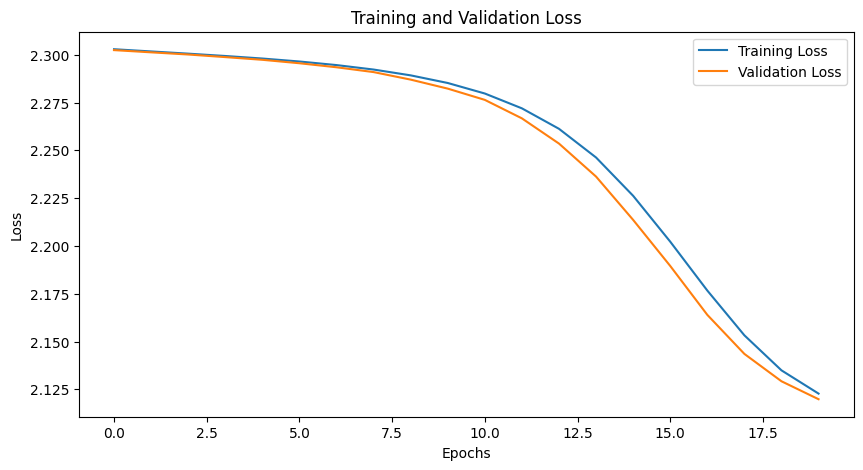

Testing model with LR=0.001, Optimizer=Adam
Epoch 1, Loss: 1.8026, Val Loss: 1.6285
Epoch 2, Loss: 1.5011, Val Loss: 1.3634
Epoch 3, Loss: 1.2768, Val Loss: 1.1680
Epoch 4, Loss: 1.1167, Val Loss: 1.0081
Epoch 5, Loss: 1.0024, Val Loss: 0.9495
Epoch 6, Loss: 0.9129, Val Loss: 0.8673
Epoch 7, Loss: 0.8423, Val Loss: 0.8661
Epoch 8, Loss: 0.7638, Val Loss: 0.8151
Epoch 9, Loss: 0.7065, Val Loss: 0.6922
Epoch 10, Loss: 0.6330, Val Loss: 0.7019
Epoch 11, Loss: 0.5925, Val Loss: 0.7087
Epoch 12, Loss: 0.5432, Val Loss: 0.6329
Epoch 13, Loss: 0.5012, Val Loss: 0.5805
Epoch 14, Loss: 0.4579, Val Loss: 0.6360
Epoch 15, Loss: 0.4195, Val Loss: 0.5945
Epoch 16, Loss: 0.3995, Val Loss: 0.5845
Epoch 17, Loss: 0.3669, Val Loss: 0.6361
Epoch 18, Loss: 0.3345, Val Loss: 0.5602
Epoch 19, Loss: 0.3102, Val Loss: 0.6001
Epoch 20, Loss: 0.2890, Val Loss: 0.6064
Training Time: 682.64 seconds


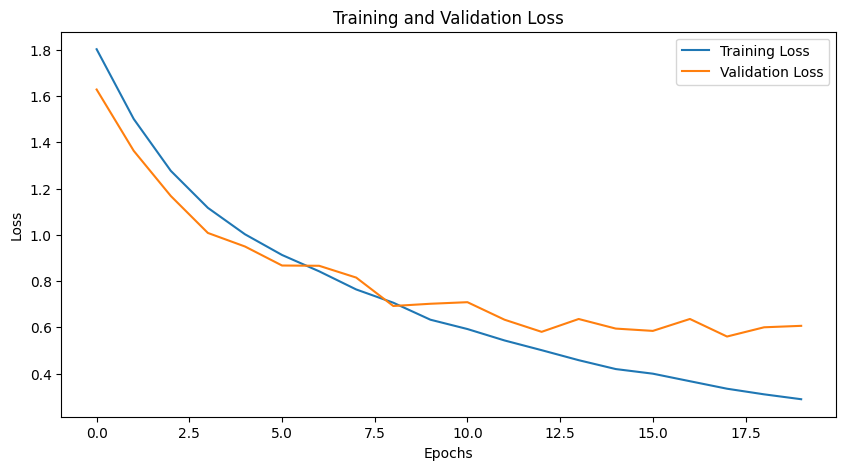

Testing model with LR=0.0001, Optimizer=SGD
Epoch 1, Loss: 2.3028, Val Loss: 2.3023
Epoch 2, Loss: 2.3026, Val Loss: 2.3021
Epoch 3, Loss: 2.3023, Val Loss: 2.3019
Epoch 4, Loss: 2.3021, Val Loss: 2.3017
Epoch 5, Loss: 2.3019, Val Loss: 2.3015
Epoch 6, Loss: 2.3017, Val Loss: 2.3013
Epoch 7, Loss: 2.3015, Val Loss: 2.3011
Epoch 8, Loss: 2.3013, Val Loss: 2.3009
Epoch 9, Loss: 2.3011, Val Loss: 2.3007
Epoch 10, Loss: 2.3009, Val Loss: 2.3005
Epoch 11, Loss: 2.3007, Val Loss: 2.3003
Epoch 12, Loss: 2.3005, Val Loss: 2.3002
Epoch 13, Loss: 2.3003, Val Loss: 2.2999
Epoch 14, Loss: 2.3001, Val Loss: 2.2997
Epoch 15, Loss: 2.2999, Val Loss: 2.2995
Epoch 16, Loss: 2.2997, Val Loss: 2.2993
Epoch 17, Loss: 2.2995, Val Loss: 2.2991
Epoch 18, Loss: 2.2993, Val Loss: 2.2989
Epoch 19, Loss: 2.2991, Val Loss: 2.2987
Epoch 20, Loss: 2.2988, Val Loss: 2.2984
Training Time: 679.46 seconds


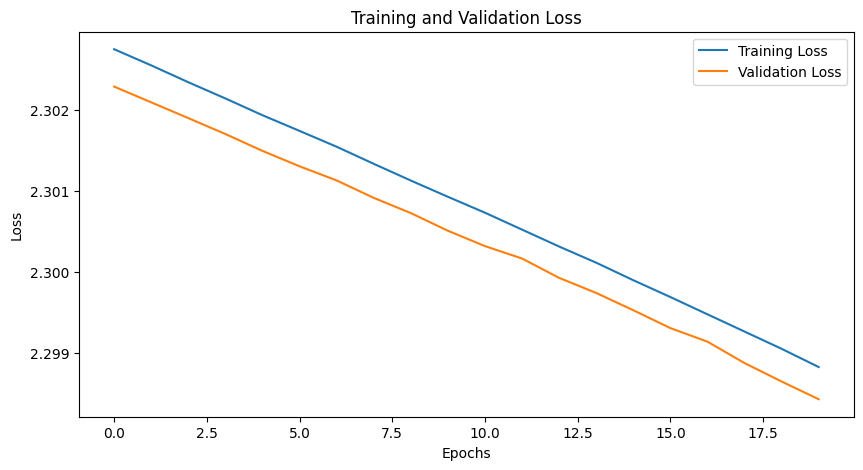

Testing model with LR=0.0001, Optimizer=Adam
Epoch 1, Loss: 1.9620, Val Loss: 1.7753
Epoch 2, Loss: 1.7043, Val Loss: 1.6501
Epoch 3, Loss: 1.6198, Val Loss: 1.5632
Epoch 4, Loss: 1.5623, Val Loss: 1.5368
Epoch 5, Loss: 1.5125, Val Loss: 1.4515
Epoch 6, Loss: 1.4621, Val Loss: 1.4545
Epoch 7, Loss: 1.4282, Val Loss: 1.3848
Epoch 8, Loss: 1.3886, Val Loss: 1.3457
Epoch 9, Loss: 1.3484, Val Loss: 1.3495
Epoch 10, Loss: 1.3197, Val Loss: 1.2930
Epoch 11, Loss: 1.2815, Val Loss: 1.2389
Epoch 12, Loss: 1.2441, Val Loss: 1.2243
Epoch 13, Loss: 1.2130, Val Loss: 1.1692
Epoch 14, Loss: 1.1780, Val Loss: 1.1967
Epoch 15, Loss: 1.1482, Val Loss: 1.1086
Epoch 16, Loss: 1.1191, Val Loss: 1.1020
Epoch 17, Loss: 1.0895, Val Loss: 1.1063
Epoch 18, Loss: 1.0620, Val Loss: 1.0692
Epoch 19, Loss: 1.0391, Val Loss: 1.0490
Epoch 20, Loss: 1.0186, Val Loss: 1.0774
Training Time: 678.16 seconds


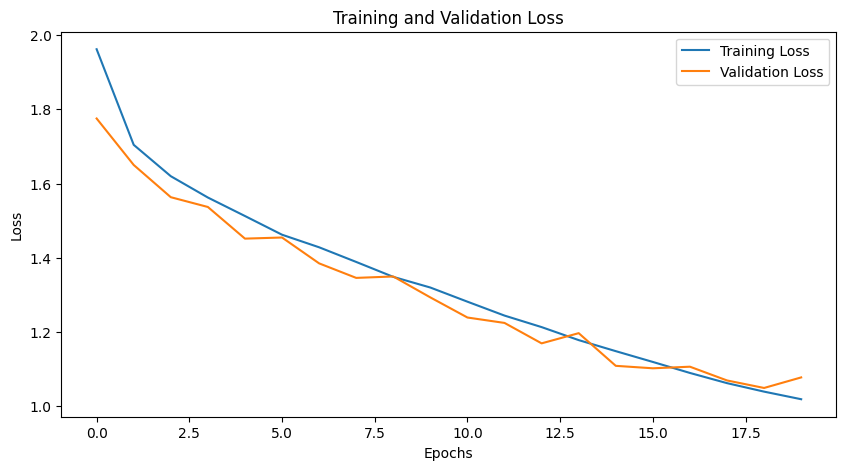

Best Hyperparameters: {'learning_rate': 0.001, 'optimizer': 'Adam'}
best_hyperparams: {'learning_rate': 0.001, 'optimizer': 'Adam'}


In [ ]:
# Run hyperparameter tuning
best_model, best_hyperparams = hyperparameter_tuning()
# print(f'best_model: {best_model}')
print(f'best_hyperparams: {best_hyperparams}')